# You might have to open the raw data file in libra office and merge the dilimiters

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Import curve fitting package from scipy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# import os
import os, sys, shutil

raw_data = pd.read_csv('pre_dilution_new_standards_09032023.csv', sep=',', header=None)


In [2]:
# get the row index of the cell that contains the string "Corrected [Bradford:595]"
row_index = raw_data.index[raw_data.loc[:,0]=="Corrected [Bradford:595]"][0]

corrected_data = raw_data.iloc[row_index+2: row_index + 10, 1 : 13].reset_index(drop=True)
print(corrected_data)

      1      2      3      4      5      6      7      8   9   10  11  12
0  0.572  0.614  0.619  0.664  0.622  0.635  0.659  0.633 NaN NaN NaN NaN
1  1.752  1.707  1.723  1.735  1.744  3.388  3.438  3.283 NaN NaN NaN NaN
2  2.156  2.168  2.160  2.090  2.228  3.009  3.008  2.972 NaN NaN NaN NaN
3  2.355  2.414  2.373  2.383  2.409  2.038  1.939  1.895 NaN NaN NaN NaN
4  2.582  2.634  2.608  2.608  2.564  1.376  1.341  1.369 NaN NaN NaN NaN
5  2.736  2.787  2.818  2.754  2.767    NaN    NaN    NaN NaN NaN NaN NaN
6  2.987  3.010  2.993  3.024  3.001    NaN    NaN    NaN NaN NaN NaN NaN
7  3.075  3.050  3.076  3.067  3.068    NaN    NaN    NaN NaN NaN NaN NaN


In [3]:
# hot fix to deal with the parser not being able to parse "blank wells".
# remove at a later date

calibrants = corrected_data.iloc[:8,0:5]
print(calibrants)
print(type(calibrants.iloc[0,0]))

       1      2      3      4      5
0  0.572  0.614  0.619  0.664  0.622
1  1.752  1.707  1.723  1.735  1.744
2  2.156  2.168  2.160  2.090  2.228
3  2.355  2.414  2.373  2.383  2.409
4  2.582  2.634  2.608  2.608  2.564
5  2.736  2.787  2.818  2.754  2.767
6  2.987  3.010  2.993  3.024  3.001
7  3.075  3.050  3.076  3.067  3.068
<class 'numpy.float64'>


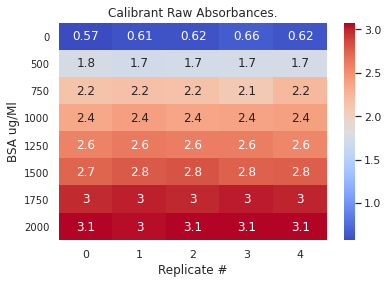

In [4]:
# reshape

calibrants_np = calibrants.to_numpy()

replicates = 5

# real concs in wells. Stocks in ug/ml diluted by 20x
#calibrant_range = ["0","500","750","1000"]
calibrant_range = ["0","500","750","1000", "1250", "1500", "1750","2000"]

#calibrants_np_2d = np.reshape(calibrants_np, (int(len(calibrants_np)/replicates), replicates))

import seaborn as sns

sns.set()
ax1 = sns.heatmap(calibrants_np, annot=True, cmap="coolwarm")
ax1.set_ylabel("BSA ug/Ml")
ax1.set_title("Calibrant Raw Absorbances.")
ax1.set_xlabel("Replicate #")
plt.yticks(np.arange(8)+0.5,calibrant_range, rotation=0, fontsize="10")

plt.savefig("output/BSA_absorbances_heat.png")

plt.show()

In [5]:
calibrants_df = pd.DataFrame(calibrants_np, columns=["Rep1", "Rep2", "Rep3", "Rep4", "Rep5"], index=calibrant_range)

calibrants_df["Mean"] = calibrants_df.mean(axis=1)
calibrants_df["SEM"] = calibrants_df.iloc[:,:3].sem(axis=1)

calibrants_df_avg = calibrants_df[["Mean", "SEM"]]


[0.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 1750.0, 2000.0]
[-348.00423801] [[ 729.67916899 -336.8180489   111.78852426]]
coefficient of determination: 0.9960677483650233


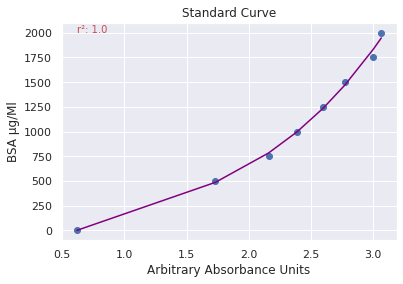

In [6]:

# calibrant concs
calibrant_range_numerical = [float(ele) for ele in calibrant_range]
print(calibrant_range_numerical)



# fitc data in to array and reverse the order
x = np.array(calibrants_df_avg["Mean"]).reshape(-1,1)

# List of nM concs into array
y = np.array(calibrant_range_numerical).reshape(-1,1)


plt.scatter(x,y)


#x = x.reshape(-1,1)

# fit curves
#function for looping?

poly = PolynomialFeatures(degree=3, include_bias=False)

poly_features = poly.fit_transform(x)

model = LinearRegression()


# Fit
model.fit(poly_features,y)


print(model.intercept_, model.coef_)


y_predicted = model.predict(poly_features)
plt.plot(x, y_predicted, color='purple')

r_sq = model.score(poly_features, y)
print('coefficient of determination:', r_sq)


textstr ='r²: ' +str(round(r_sq,2))
plt.text(calibrants_df_avg["Mean"].min(), calibrant_range_numerical[-1], textstr, color='r', fontsize=10)

plt.title('Standard Curve')
plt.xlabel('Arbitrary Absorbance Units')
plt.ylabel('BSA μg/Ml')
plt.savefig("output/BSA_Standard_Curve.png")
plt.show()




In [7]:

def process_sample_data(sample_name, sample_data_df, dilution_list, replicate_list):
    
    replicates = len(replicate_list)
    
    
    ## label sample df with metadata
    sample_data_df.columns = replicate_list
    sample_data_df.index = dilution_list

    
    # heatmap of absorbances
    sns.set()
    sns.heatmap(sample_data_df, annot=True, cmap="coolwarm")
    plt.ylabel("Dilution Factor")
    plt.title(sample_name + " : Absorbances of Diluted samples")
    plt.xlabel("Replicate #")
    plt.yticks(np.arange(sample_data_df.shape[0])+0.5, dilution_list, rotation=0, fontsize="10")
    plt.savefig("output/"+sample_name+"_Sample_Absorbances_heat.png")
    plt.show()
    
    # generate the means
    sample_data_df["Mean"] = sample_data_df.mean(axis=1)
    sample_data_df["SEM"] = sample_data_df.iloc[:,:3].sem(axis=1)
    samples_df_avg = sample_data_df[["Mean", "SEM"]]
    
    
    ax3 = samples_df_avg.plot(kind="bar", yerr="SEM", legend=False)
    ax3.set_title(sample_name + " : Mean Absorbances of Sample Dilutions")
    ax3.set_ylabel("Absorbance")
    ax3.set_xlabel("Dilution Factor")
    plt.xticks(np.arange(samples_df_avg.shape[0]),dilution_list, rotation=0, fontsize="10")
    plt.savefig("output/"+sample_name+"_Sample_Absorbances_Bar.png")
    plt.show()


    #### subset samples that don't fall in linear range
    acceptable_samples = sample_data_df

    #get the index again for the names
    acceptable_samples_list = acceptable_samples.index
    
    

    # convert samples
    x = np.array(acceptable_samples.iloc[:,:3]).reshape(-1,1)
    
    sample_absorbances_poly_features = poly.fit_transform(x)
    
    predicted_ug_per_ml = model.predict(sample_absorbances_poly_features)
    predicted_ug_per_ml = np.reshape(predicted_ug_per_ml,(int(len(predicted_ug_per_ml)/replicates), replicates))
    predicted_ug_per_ml = pd.DataFrame(predicted_ug_per_ml, columns=replicate_list, index = acceptable_samples_list)


    #account for the dilutions
    numrows = predicted_ug_per_ml.shape[0]
    
    for index, row in predicted_ug_per_ml.iterrows():
        # get the dilution factor from the index
        ind = str(index)
        ind = ind[:-1]
        ind = int(ind)
        
        print(ind)

        predicted_ug_per_ml.loc[index, "Rep1"] = predicted_ug_per_ml.loc[index, "Rep1"] * ind
        predicted_ug_per_ml.loc[index, "Rep2"] = predicted_ug_per_ml.loc[index, "Rep2"] * ind
        predicted_ug_per_ml.loc[index, "Rep3"] = predicted_ug_per_ml.loc[index, "Rep3"] * ind
        

    # Use that to perform that calculations just on the right columns
    # recalculate mean and SEM

    predicted_ug_per_ml['ug/ml'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index),replicate_list].mean(axis=1)
    predicted_ug_per_ml['ug/ml SEM'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index), replicate_list].sem(axis=1)


    #get index to use and names
    predicted_ug_per_ml = predicted_ug_per_ml.reset_index()
    #convert all to strings
    predicted_ug_per_ml['index'] = predicted_ug_per_ml['index'].astype(str)

    ######################### convert ug/ml to mg/ml
    # grab the raw values
    predicted_mg_per_ml = predicted_ug_per_ml[replicate_list]
    # convert
    predicted_mg_per_ml = predicted_mg_per_ml/1000
    # append index
    predicted_mg_per_ml['index'] = predicted_ug_per_ml['index']


    ####################### generate means and stats
    predicted_mg_per_ml['mg/ml'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),replicate_list].mean(axis=1)
    predicted_mg_per_ml['mg/ml SEM'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),replicate_list].sem(axis=1)


    samples_bar_av_df = predicted_mg_per_ml[["mg/ml", "mg/ml SEM"]]


    ax4 = samples_bar_av_df.plot(kind="bar", yerr="mg/ml SEM", legend=False)
    ax4.set_title(sample_name + " : Samples Mean Concentrations & SEMs")
    ax4.set_ylabel("Concentration in Mg/Ml")
    ax4.set_xlabel("Dilution Factor")
    plt.xticks(np.arange(samples_bar_av_df.shape[0]),acceptable_samples_list, rotation=0, fontsize="10")
    plt.savefig("output/"+sample_name+"_Conc_bar.png")
    plt.show()

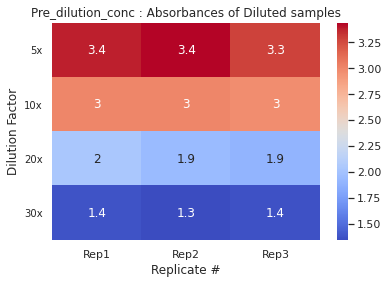

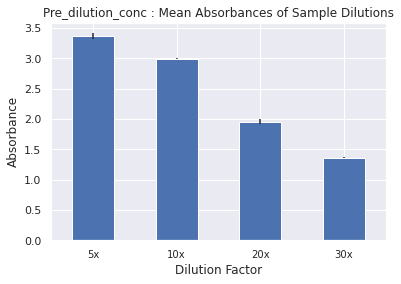

5
10
20
30


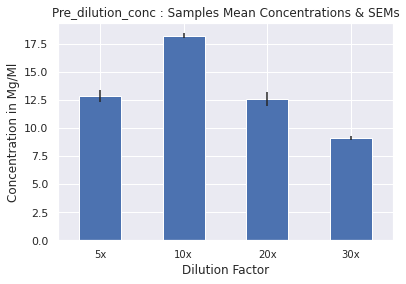

In [8]:
sample_data = corrected_data.iloc[1:5, 5:8]


sample_list = ["5x","10x", "20x", "30x"]

replicate_list = ["Rep1", "Rep2", "Rep3"]

process_sample_data("Pre_dilution_conc", sample_data, sample_list, replicate_list)

      9      10     11
6  2.429  2.418  2.439
7  1.284  1.334  1.333
      9      10     11
8  2.757  2.741  2.835
9  1.346  1.314  1.246


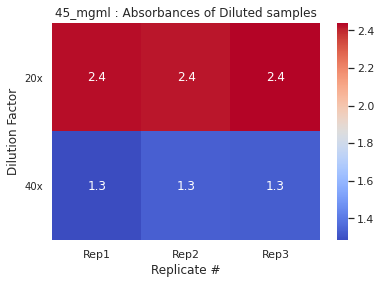

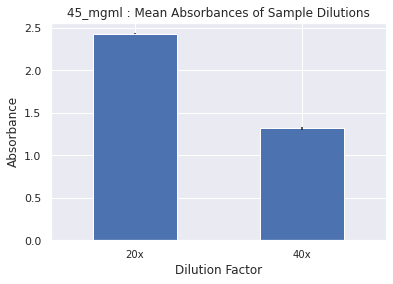

20
40


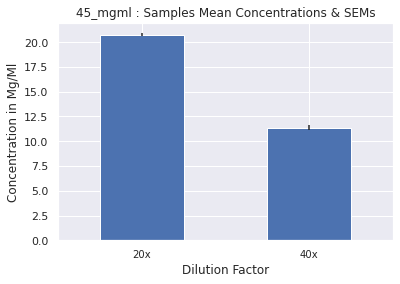

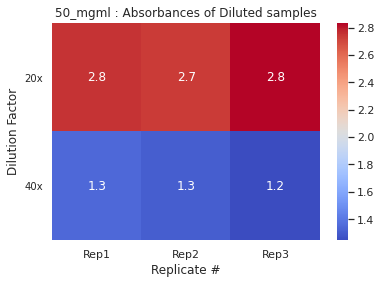

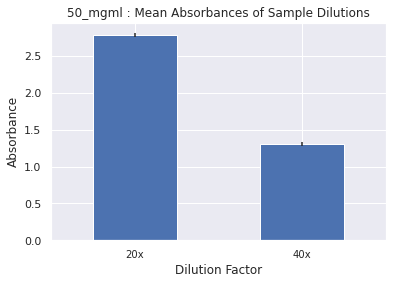

20
40


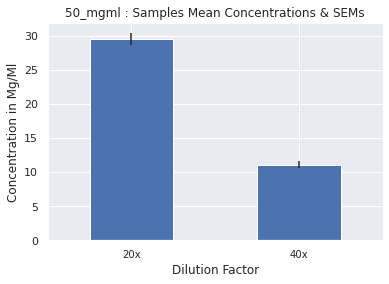

In [9]:
Standards = pd.read_csv('standards_45_50_230309_OT2_BRADFORD.csv', sep=',', header=None)

#print(Standards)

mgml_45 = Standards.iloc[6:8,9:12]

mgml_50 = Standards.iloc[8:10,9:12]

print(mgml_45)
print(mgml_50)

replicates = 3

sample_list = ["20x", "40x"]

replicate_list = ["Rep1", "Rep2", "Rep3"]

process_sample_data("45_mgml", mgml_45, sample_list, replicate_list)
process_sample_data("50_mgml", mgml_50, sample_list, replicate_list)